# Seafood farm process improvement
[*A DataCamp challenge*](https://datacamp.com)

![](img/abalone.jpg)

Nov, 2022
> ML —Linear Regression

## The project
You are working as an intern for an abalone farming operation in Japan. For operational and environmental reasons, it is an important consideration to estimate the age of the abalones when they go to market.

Determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope. Since this method is somewhat cumbersome and complex, you are interested in helping the farmers estimate the age of the abalone using its physical characteristics.

Create a report that covers the following:
- How does weight change with age for each of the three sex categories?
- Can you estimate an abalone's age using its physical characteristics?
- Investigate which variables are better predictors of age for abalones.

## The data
You have access to the following historical data (source) and abalone characteristics:

- `sex` - M, F, and I (infant).
- `length` - longest shell measurement.
- `diameter` - perpendicular to the length.
- `height` - measured with meat in the shell.
- `whole_wt` - whole abalone weight.
- `shucked_wt` - the weight of abalone meat.
- `viscera_wt` - gut-weight.
- `shell_wt` - the weight of the dried shell.
- `rings` - number of rings in a shell cross-section.
- `age` - the age of the abalone: the number of rings + 1.5.

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

abalone = pd.read_csv("data/abalone.csv")
abalone

,sex,length,diameter,height,whole_wt,shucked_wt,viscera_wt,shell_wt,rings,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,8.5
...,...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,12.5
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,11.5
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,10.5
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,11.5


## Data validation

In [2]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sex         4177 non-null   object 
 1   length      4177 non-null   float64
 2   diameter    4177 non-null   float64
 3   height      4177 non-null   float64
 4   whole_wt    4177 non-null   float64
 5   shucked_wt  4177 non-null   float64
 6   viscera_wt  4177 non-null   float64
 7   shell_wt    4177 non-null   float64
 8   rings       4177 non-null   int64  
 9   age         4177 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 326.5+ KB


There are no missing values nor duplicated rows.

In [3]:
# Look for duplicated rows
print(f"Duplicated rows: {abalone.duplicated().sum()}")

Duplicated rows: 0


I will change `sex` to `category` data type and then we are ready to go.

In [4]:
# Change data type to category
abalone = abalone.astype({"sex": "category"})

abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   sex         4177 non-null   category
 1   length      4177 non-null   float64 
 2   diameter    4177 non-null   float64 
 3   height      4177 non-null   float64 
 4   whole_wt    4177 non-null   float64 
 5   shucked_wt  4177 non-null   float64 
 6   viscera_wt  4177 non-null   float64 
 7   shell_wt    4177 non-null   float64 
 8   rings       4177 non-null   int64   
 9   age         4177 non-null   float64 
dtypes: category(1), float64(8), int64(1)
memory usage: 298.0 KB


## Exploratory analysis
First, we will visually explore how `age` correlates with the physical characteristics of the abalone.

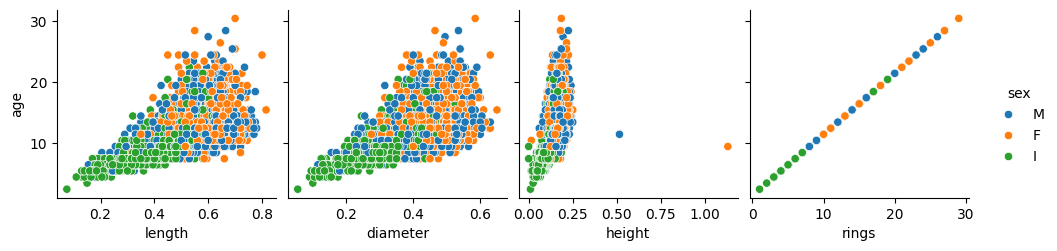

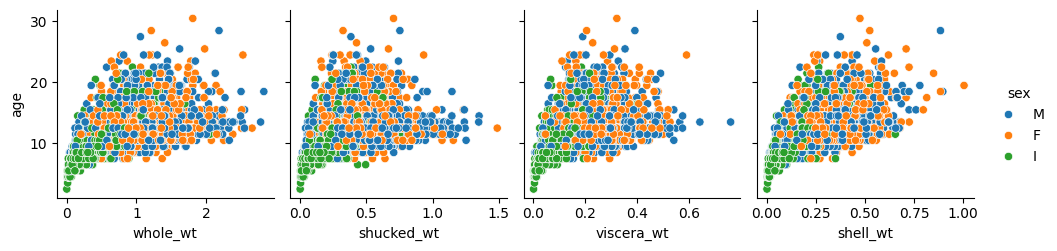

In [5]:
# Color order in plots
hue_order = ["M", "F", "I"]

# Plot target "age" vs features in two rows to better visualize it
sns.pairplot(
    abalone,
    x_vars=["length", "diameter", "height", "rings"],
    y_vars=["age"],
    hue="sex",
    hue_order=hue_order,
)

sns.pairplot(
    abalone,
    x_vars=["whole_wt", "shucked_wt", "viscera_wt", "shell_wt"],
    y_vars=["age"],
    hue="sex",
    hue_order=hue_order,
)

plt.show()

Number of `rings` has a direct correspondence with `age`, as stated in the project description, and so either of them is the target variable.

Let's remove those two outliers in the `height` plot, because they are surely distorting the shape of the graph that is showed to us.

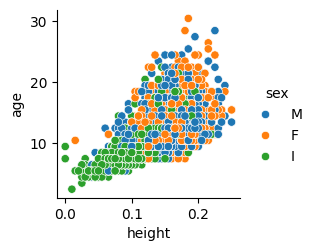

In [6]:
# Consider only heights below this
lim_height = 0.4
abalone = abalone.loc[abalone["height"] < lim_height, :]

# Plot "age" vs. "height"
sns.pairplot(abalone, x_vars=["height"], y_vars=["age"], hue="sex", hue_order=hue_order)

plt.show()

Now the shape of `height` vs `age` appears to be similar to the ones of `length` and `diameter`. The relationship between these size measures and the age looks linear. This is reasonable: as abalones grow older they get proportionally bigger (but with a high variance!).

On the other hand, in the previous plots in the second row, related to weights, the relationship looks quadratic. This is not surprising either because as the abalone grows in size, its body volume does not grow linearly, but at a higher rate (think about the round shell of the abalone: the diameter increases linearly with age, but the area that it comprises —and may be covered with flesh— grows with the square of that diameter).

Let's take a look at the correlation matrix:

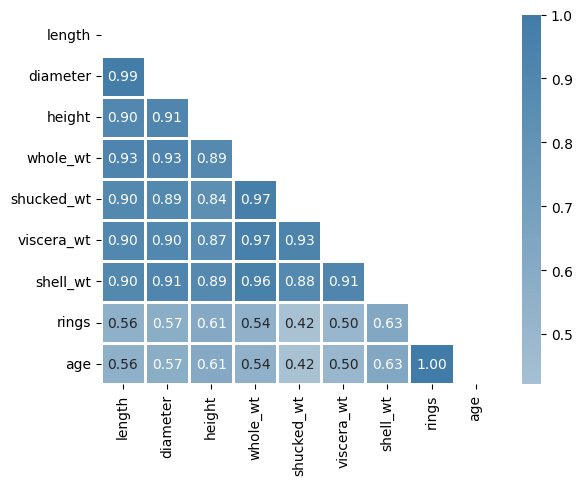

In [7]:
# Get pearson correlation matrix from the numeric types of the df
corr = abalone.select_dtypes(include=np.number).corr()

# Plot it with a heatmap
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, center=0, cmap=cmap, linewidths=1, annot=True, fmt=".2f")

plt.show()

We can see that some of the features have high correlation coefficients between them. The highest one (apart from the obvious `rings`-`age` direct correspondence) can be found between `length` and `diameter`: 0.99. This makes sense because `diameter` and `length` both must refer approximately to the same distance. So we could probably drop one of them without losing much information for prediction purposes.

We have to be careful though with these correlation coefficients. A bunch of them are higher than 90% but that does not mean we can directly reduce dimensionality as in the case of  `length` vs `diameter`. For example, consider the coefficient between `whole_wt` and `lenght`: 0.93. It is indeed high, but the thing is `whole_wt` and `lenght` are not linearly related (as it is shown in the plot just below) so we cannot conclude anything from a _pearson coefficient that only makes sense in linear relationships_.

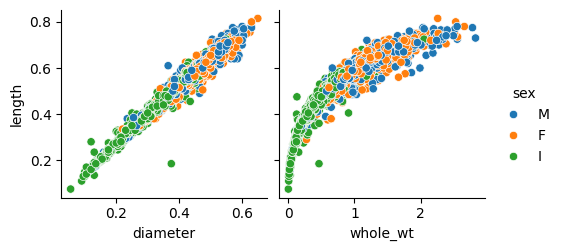

In [8]:
# Plot to see linear and quadratic relationship
sns.pairplot(
    abalone,
    x_vars=["diameter", "whole_wt"],
    y_vars=["length"],
    hue="sex",
    hue_order=hue_order,
)

plt.show()

See the linear relationship (left) vs non-linear relationship (right).

If I dropped `whole_wt` because of the high correlation coefficients it has with other features, I would be making a great mistake, as we will see in a moment.

## Best predictors
So I am not dropping any feature for now and I will consider all 7 of them to calculate the best predictors among them. I will do this for each `sex` separately, to solve the problem more precisely.

It is worth mentioning that for this approach to work, differentiating "M", "F" and "I" should be no problem in the seafood farm (because the models we are going to use are going to be different for each of them). Infant abalones surely are smaller than adult ones, and male and female adults should differ in physical traits that makes it easy to sort them out.

I will use a Lasso regressor to asses the importance of each feature, specifically a `LassoCV()` class to automatically calculate by Cross Validation the optimum "alpha" hyperparameter. As a result I will get the coefficient parameters, which are a measure of the predictive power of each variable.

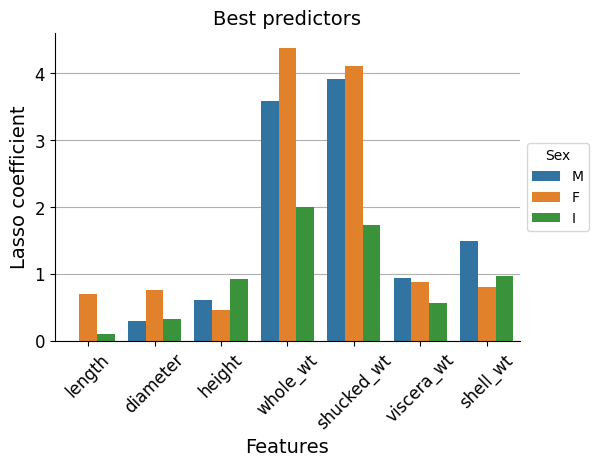

In [9]:
# Segment the abalone dataset by "sex"
abalones = {
    "M": abalone.loc[abalone["sex"] == "M", :].copy(),
    "F": abalone.loc[abalone["sex"] == "F", :].copy(),
    "I": abalone.loc[abalone["sex"] == "I", :].copy(),
}

# Define the feature set
features = [
    "length",
    "diameter",
    "height",
    "whole_wt",
    "shucked_wt",
    "viscera_wt",
    "shell_wt",
]

# Define the target
target = ["age"]

# Get coeficients
coefs = {}

for sex, abal in abalones.items():

    # Split features and target
    X = abal[features].values
    y = abal[target].values

    # Scale X values
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # LassoCV model
    lacv = LassoCV()
    lacv.fit(X_std, y.ravel())  # <- flatten y array

    # Get the resulting coefficients' absolute values
    coefs[sex] = list(np.abs(lacv.coef_))

# Create df for plotting
coefs_df = pd.DataFrame(coefs, index=features)
coefs_df = (
    coefs_df.reset_index()
    .melt(id_vars="index")
    .rename(columns={"index": "feature", "variable": "sex", "value": "coef"})
)

# Plot coefficients
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(ax=ax, x="feature", y="coef", data=coefs_df, hue="sex", hue_order=hue_order)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=12, rotation=45)
ax.tick_params(axis="y", labelsize=12)
ax.set_title("Best predictors", size=14)
ax.set_xlabel("Features", fontsize=14)
ax.set_ylabel("Lasso coefficient", fontsize=14)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", title="Sex", fontsize=10)
sns.despine()

plt.show()

We can see that `whole_wt` and `shucked_wt` stand out as best predictors.

Now let's check if this is really the case.

## Feature selection
We will measure the score of the predictions (R-squared) and the mean error of them (RMSE) for all the features' combinations that are possible.

A simple linear regression model will be used. We will feed it with polynomial features of second degree, because as mentioned, there is a quadratic relationship between the weights (which are presumably best predictors) and age.

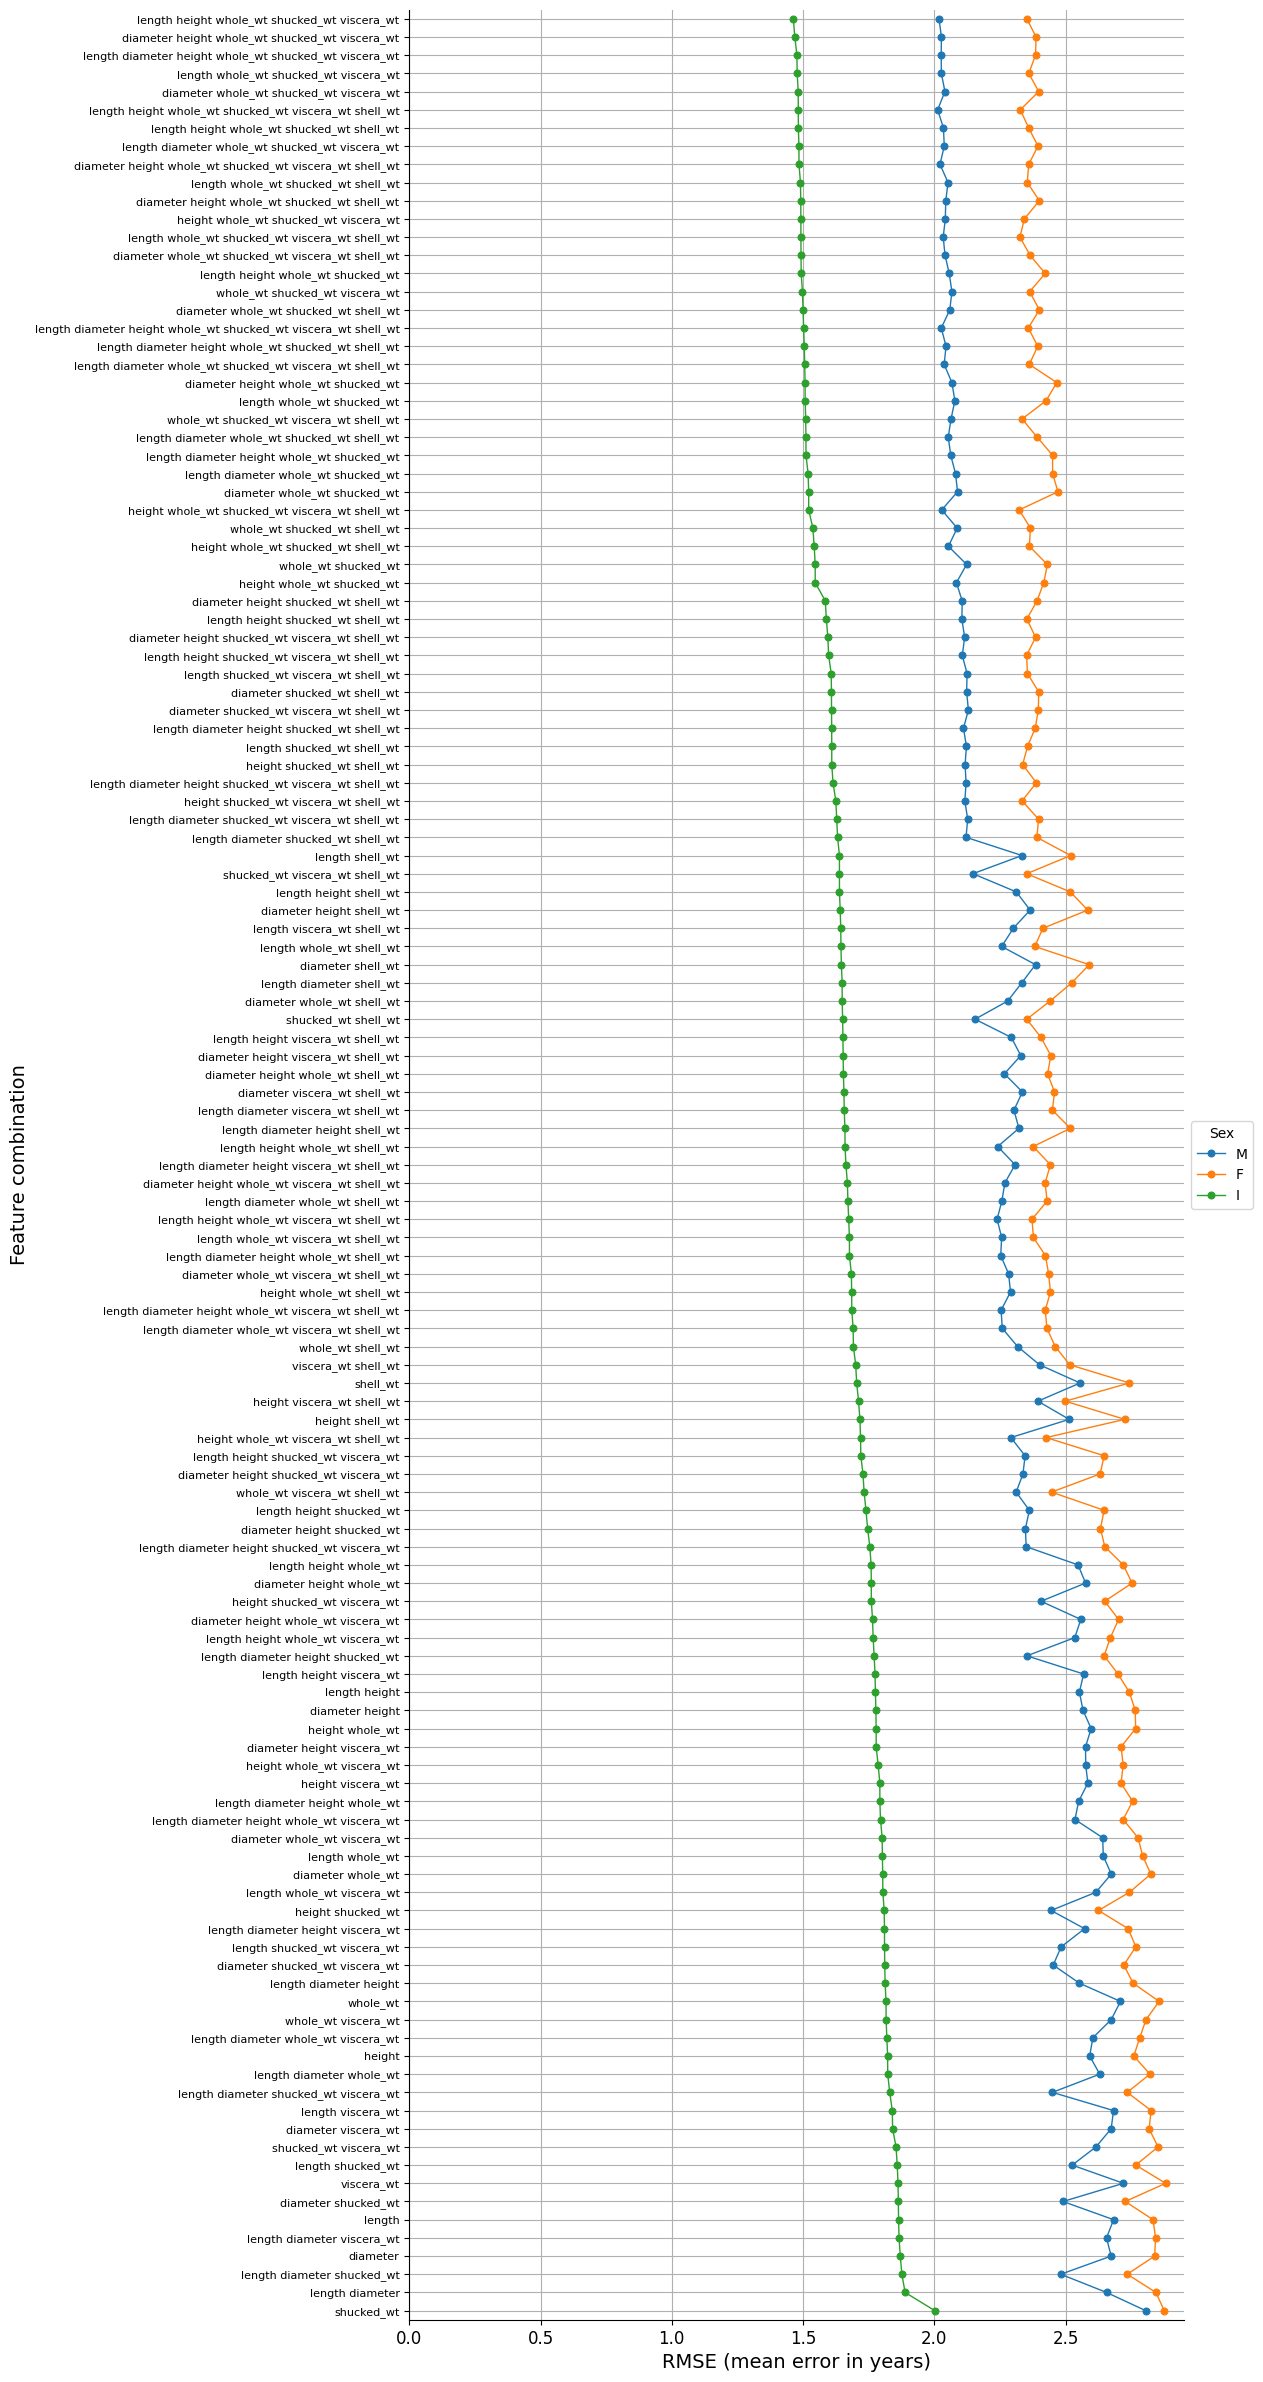

In [10]:
# Create a list containing lists of features combinations
feature_combinations = []

# Iterate through number of features selected: make groups of 1 to 7 features
for selected in range(1, len(features) + 1):
    # Iterate through all the combinations
    for tpl in itertools.combinations(features, selected):
        feature_combinations.append(list(tpl))  # Save tuple as list


# Iterate through all feature combinations
combination_lst_ = []
combination_lst = []
combination_lst_n = []
sex_lst = []
r_squared_lst = []
rmse_lst = []

for combination in feature_combinations:

    for sex, abalone in abalones.items():

        # Split features and target
        X = abalone[combination].values
        y = abalone[target].values

        # Split train-test data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale X
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        X_test_std = scaler.transform(X_test)

        # Insert polynomial features
        poly = PolynomialFeatures(degree=2)
        X_train_std_poly = poly.fit_transform(X_train_std)
        X_test_std_poly = poly.fit_transform(X_test_std)

        # Linear Regression model
        linreg = LinearRegression()
        linreg.fit(X_train_std_poly, y_train)
        y_pred = linreg.predict(X_test_std_poly)

        # Calculate evaluation metrics
        r_squared = linreg.score(X_test_std_poly, y_test)
        rmse = root_mean_squared_error(y_test, y_pred)

        # Store result
        combination_lst_.append(combination)
        combination_lst.append(" ".join(combination))  # <- join as strings
        combination_lst_n.append(len(combination))  # <- nº of features
        sex_lst.append(sex)
        r_squared_lst.append(r_squared)
        rmse_lst.append(rmse)

# Store data in df for analysis and plotting
combinations_df = (
    pd.DataFrame(
        [
            combination_lst,
            sex_lst,
            r_squared_lst,
            rmse_lst,
            combination_lst_n,
            combination_lst_,
        ]
    )
    .transpose()
    .rename(
        columns={
            0: "features",
            1: "sex",
            2: "R^2",
            3: "RMSE",
            4: "n_features",
            5: "feature_set",
        }
    )
)
combinations_df = combinations_df.sort_values(by="R^2", ascending=False)
combinations_df = combinations_df.reset_index(
    drop=True
)  # Reset index to later check ranking

# Plot
fig, ax = plt.subplots(figsize=(10, 30))
sns.pointplot(
    ax=ax,
    x="RMSE",
    y="features",
    data=combinations_df,
    hue="sex",
    hue_order=hue_order,
    orient="y",
    markersize=5,
    linewidth=1,
)

ax.grid(axis="both")
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=12, rotation=0)
ax.tick_params(axis="y", labelsize=8, rotation=0)
ax.set_title("", size=16)
ax.set_xlabel("RMSE (mean error in years)", fontsize=14)
ax.set_ylabel("Feature combination", fontsize=14)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", title="Sex", fontsize=10)
ax.set_xlim(0)
sns.despine()

plt.show()

The best result is given by the set that has the minimum error, that is to say:

In [11]:
best_feature_set = combinations_df.loc[0, "feature_set"]
best_feature_set

['length', 'height', 'whole_wt', 'shucked_wt', 'viscera_wt']

If we are looking for a group of 2 variables, the combination that obtains the best results is this one:

In [12]:
best_2_feature_set = combinations_df.loc[
    combinations_df["n_features"] == 2, "feature_set"
].iloc[0]
best_2_feature_set

['whole_wt', 'shucked_wt']

Which is precisely the two features set that we found were most predictive.

Let's plot expected vs predicted ages for both cases:

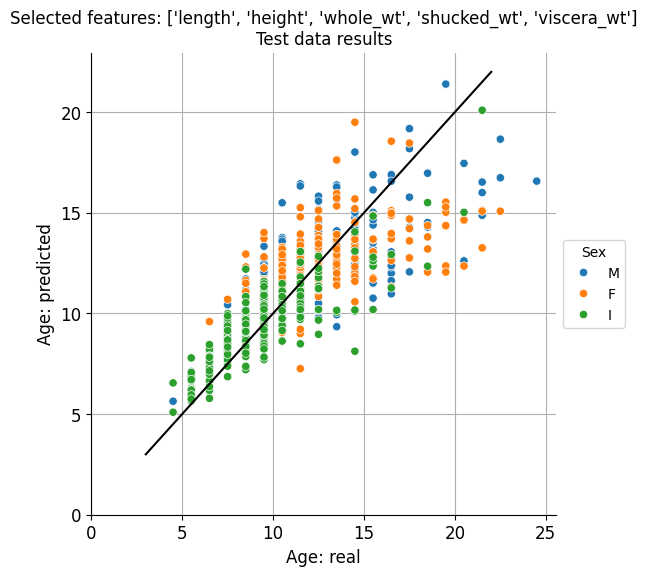

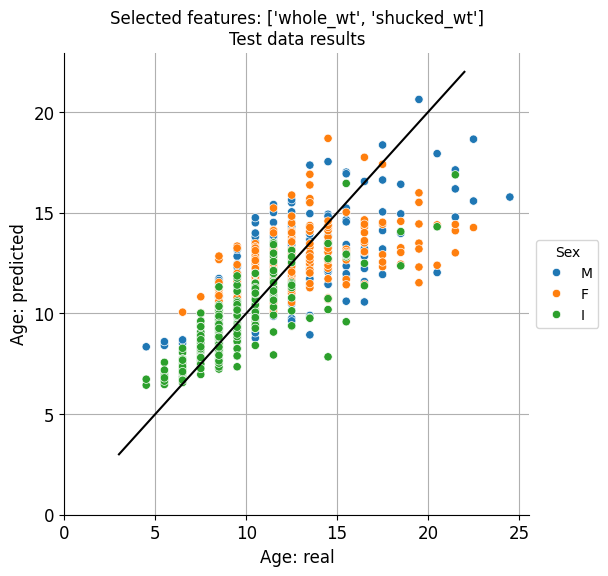

In [13]:
# Define function for DRY (Don't Repeat Yourself)
def plot_prediction(features):
    ages_real = []
    ages_pred = []
    sexes = []

    for sex, abalone in abalones.items():

        # Split features and target
        X = abalone[features].values
        y = abalone[target].values

        # Split train-test data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale X
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_std = scaler.transform(X_train)
        X_test_std = scaler.transform(X_test)

        # Insert polynomial features
        poly = PolynomialFeatures(degree=2)
        X_train_std_poly = poly.fit_transform(X_train_std)
        X_test_std_poly = poly.fit_transform(X_test_std)

        # Linear Regression model
        linreg = LinearRegression()
        linreg.fit(X_train_std_poly, y_train)
        y_pred = linreg.predict(X_test_std_poly)

        ages_real.extend(y_test.reshape(-1).tolist())
        ages_pred.extend(y_pred.reshape(-1).tolist())

        # Save category
        sexes.extend([sex] * len(y_pred))

    # Store data in df for plotting
    plot_df = (
        pd.DataFrame([ages_real, ages_pred, sexes])
        .transpose()
        .rename(columns={0: "real_age", 1: "predicted_age", 2: "sex"})
    )

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    sns.scatterplot(
        ax=ax,
        x="real_age",
        y="predicted_age",
        data=plot_df,
        hue="sex",
        hue_order=hue_order,
    )

    # Plot the reference line
    sns.lineplot(ax=ax, x=np.arange(3, 23, 1), y=np.arange(3, 23, 1), color="black")

    ax.grid(axis="both")
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", labelsize=12, rotation=0)
    ax.tick_params(axis="y", labelsize=12)
    ax.set_title(f"Selected features: {features}\nTest data results", size=12)
    ax.set_xlabel("Age: real", fontsize=12)
    ax.set_ylabel("Age: predicted", fontsize=12)
    ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", title="Sex", fontsize=10)
    ax.set_xlim(0)
    ax.set_ylim(0)
    sns.despine()

    plt.show()


# Plot
plot_prediction(best_feature_set)
plot_prediction(best_2_feature_set)

Visually at least, there doesn't seem to be a remarkable difference, in accordance to the minimal difference existing between the predictive results obtained for these two sets of features.

## Conclusion
Best results were clearly obtained for the infant abalone, with a mean error of around 1.5 years. And it could be the case that, for economical reasons, normally a few-years-old (infant) abalones are commercialised.

The great thing is that just weighting `whole_wt` and `shucked_wt` we can fairly predict the age, and these two features can conveniently be measured in the product processing stage, during which abalones are shucked before being packaged.